# Predicting Term Deposit Plan Subscription by Banks

In [8]:
pip install xgboost

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score  #tp / (tp + fp)
from sklearn.metrics import f1_score         #F1 = 2 * (precision * recall) / (precision + recall)
from sklearn.metrics import recall_score     #tp / (tp + fn)
from sklearn.metrics import roc_auc_score    #Area under Recall() V/s (1-specificity)

# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [22]:
data = pd.read_csv("bank-additional-full.csv", sep=";")   #Load the data

In [23]:
data.shape

(41188, 21)

### Dropping Duplicate Rows

In [24]:
data = data.drop_duplicates()

### Dropping the duration column as its value is known after the client saying yes or no and it is highly correlated with outcome.

In [25]:
data.drop(labels="duration",axis=1,inplace=True)       

_____________________
# EDA to study the effect of some significant feature by frequency observation:

In [26]:
df = data
categorical = [var for var in df.columns if df[var].dtype=='O']   

### List of categorical features in the data

In [27]:
categorical

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

___________________________
### Checking the contribution of categories of each categorical feature

In [28]:
for var in categorical:                            #Checking the contribution of categories of each categorical feature
    print(df[var].value_counts()/np.float(len(df)))
    print("____________________________")

admin.           0.253036
blue-collar      0.224718
technician       0.163663
services         0.096343
management       0.071012
retired          0.041723
entrepreneur     0.035360
self-employed    0.034510
housemaid        0.025743
unemployed       0.024626
student          0.021250
unknown          0.008014
Name: job, dtype: float64
____________________________
married     0.605231
single      0.280843
divorced    0.111983
unknown     0.001943
Name: marital, dtype: float64
____________________________
university.degree      0.295415
high.school            0.231008
basic.9y               0.146809
professional.course    0.127259
basic.4y               0.101418
basic.6y               0.055639
unknown                0.042015
illiterate             0.000437
Name: education, dtype: float64
____________________________
no         0.791165
unknown    0.208762
yes        0.000073
Name: default, dtype: float64
____________________________
yes        0.523873
no         0.452084
unknown    0.0

### We observe that 60% clients in the data are married. So, checking if married people are more inclined towards subscribing term deposit

In [29]:
df_married = df[df["marital"]=="married"]
df_married[df_married["y"]=="yes"].count()[0]/df[df["y"]=="yes"].count()[0], df_married[df_married["y"]=="yes"].count()[0]/df_married.count()[0]

(0.5455917223539556, 0.10156093254684805)

#### This suggests that the 60 percent married people contribute to 54% of the total positive conversions
#However, only 10% of the married people were positive conversions which almost follows the actual positive conversion ratio.
_______________________________________________________________________________________

### Again we observe that 82% of the client in the data dont have loan. So, checking if no loan people are more inclined towards subscribing term deposit

In [30]:
df_loan = df[df["loan"]=="no"]
df_loan[df_loan["y"]=="yes"].count()[0]/df[df["y"]=="yes"].count()[0], df_loan[df_loan["y"]=="yes"].count()[0]/df_loan.count()[0]

(0.8297046777322699, 0.11341269373563558)

#### This suggests that the 82 % of people with no loan contribute to 82% of the total positive conversions
#However, only 11% of the no loan people were positive conversions which almost follows the actual positive conversion ratio.
__________________________________________________________________________________________________________

### Checking the cardinality of each feature:

In [31]:
for var in categorical:           #Checking the cardinality of each feature.
    print(var, ' contains ', len(df[var].unique()), ' labels')

job  contains  12  labels
marital  contains  4  labels
education  contains  8  labels
default  contains  3  labels
housing  contains  3  labels
loan  contains  3  labels
contact  contains  2  labels
month  contains  10  labels
day_of_week  contains  5  labels
poutcome  contains  3  labels
y  contains  2  labels


_____________________________________________
### The numerical features:

In [32]:
numerical = [var for var in df.columns if df[var].dtype!='O']                 
print('There are {} numerical variables\n'.format(len(numerical)))
print('The numerical variables are :', numerical)

There are 9 numerical variables

The numerical variables are : ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


# Preparing the data for model:

In [33]:
data.shape, data[data["y"]=="yes"].count()[0]/ data[data["y"]=="no"].count()[0]   #Only 12 percent yes

((41176, 20), 0.12696718395051593)

In [34]:
Y = data["y"]
X = data.drop(labels="y", axis = 1)

In [35]:
X_dum = pd.get_dummies(X)

In [36]:
X_dum.shape, len(Y)

((41176, 62), 41176)

In [37]:
le = preprocessing.LabelEncoder()
le.fit(["yes","no"])
Y_num = le.transform(Y)
print(le.inverse_transform([0,0,1]))
print(le.classes_)

['no' 'no' 'yes']
['no' 'yes']


In [38]:
type(Y.values), type(Y_num)

(numpy.ndarray, numpy.ndarray)

In [39]:
for i in range(len(Y)):    #cross-checking if any mismatch
    if not((Y.values[i]=="yes" and Y_num[i]==1)or(Y.values[i]=="no" and Y_num[i]==0)):
        print("error")

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_dum, Y_num, test_size=0.2, random_state=42, stratify=Y_num)

In [41]:
labels = list(X_test.columns)
for i in labels:
    if "unknown" in i:
        c = X_test[X_test[i]==1].count()[0]
        print(i," :unknowns-> ",c)

job_unknown  :unknowns->  63
marital_unknown  :unknowns->  12
education_unknown  :unknowns->  341
default_unknown  :unknowns->  1739
housing_unknown  :unknowns->  211
loan_unknown  :unknowns->  211


In [42]:
X_train.shape, X_test.shape, len(y_train), len(y_test)

((32940, 62), (8236, 62), 32940, 8236)

In [43]:
y_train.sum()/len(y_train), y_test.sum()/len(y_test)

(0.11265938069216758, 0.11267605633802817)

In [44]:
y_train.sum(), len(y_train), y_test.sum(), len(y_test)

(3711, 32940, 928, 8236)

In [45]:
type(X_train), type(X_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 numpy.ndarray,
 numpy.ndarray)

In [46]:
X_train.tail()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
33267,26,1,999,0,-1.8,92.893,-46.2,1.291,5099.1,0,...,0,0,0,0,0,1,0,0,1,0
22714,35,5,999,0,1.4,93.444,-36.1,4.964,5228.1,0,...,0,0,1,0,0,0,0,0,1,0
6971,32,1,999,0,1.1,93.994,-36.4,4.860,5191.0,0,...,0,0,0,0,1,0,0,0,1,0
18503,34,1,999,0,1.4,93.918,-42.7,4.968,5228.1,0,...,0,0,0,0,1,0,0,0,1,0
24790,35,1,999,0,-0.1,93.200,-42.0,4.153,5195.8,1,...,0,0,0,0,0,1,0,0,1,0


## Function to remove unknown entry rows

In [47]:
def remove_unknown_entries(dataX, dataY, unknown_label = "unknown"):
    data1 = dataX
    data1["y"] = dataY
    labels = list(data1.columns)
    for i in labels:
        if "unknown" in i:
            c = data1[data1[i]==1].count()[0]
            d = len(data1)
            print(i," :unknowns-> ",c)
            data1 = data1.loc[data1[i]==0]
            print("removed", d-len(data1))
    print("Total removed: ",dataX.shape[0]-data1.shape[0])
    Y = data1["y"]
    X = data1.drop(labels="y",axis=1)
    data1 = data1.drop(labels="y",axis=1)
    return(X,Y)

In [48]:
from sklearn.utils import resample    #Just to depict the use of shuffle
from sklearn.utils import shuffle
y = data.head()
shuffle(y, random_state = 1)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Function to Balance the data with 1:K ratio of yes's and no's

In [49]:
def balance_by_y(dataX, dataY, k=1):
    data1 = dataX
    data1["y"] = dataY
    yes = data1[data1["y"]==1]
    no = data1[data1["y"]==0]
    if k>(len(no)/len(yes)):
        print("K is higher than the allowed range")
        return dataX, dataY
    new_len = int(k*len(yes))
    no = resample(no,n_samples=new_len, replace=False, random_state=0)
    print("yes count:",len(yes)," no count:",len(no))
    data = pd.concat([yes,no])
    data = shuffle(data, random_state=0)
    Y = data["y"]
    X = data.drop(labels="y", axis=1)
    data = data.drop(labels="y", axis=1)
    return X,Y

In [50]:
X_train_1, y_train_1 = remove_unknown_entries(X_train, y_train)  #doubt
if "y" in X_train.columns:
    X_train = X_train.drop(labels="y", axis=1)

job_unknown  :unknowns->  267
removed 267
marital_unknown  :unknowns->  60
removed 60
education_unknown  :unknowns->  1279
removed 1279
default_unknown  :unknowns->  6340
removed 6340
housing_unknown  :unknowns->  584
removed 584
loan_unknown  :unknowns->  0
removed 0
Total removed:  8530


<ipython-input-47-3de063737a37>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1["y"] = dataY


In [51]:
X_train_2, y_train_2 = balance_by_y(X_train_1, y_train_1)  #downsampling after removing unknowns
if "y" in X_train_1.columns:
    X_train_1 = X_train_1.drop(labels="y", axis=1)    #check

yes count: 3063  no count: 3063


In [52]:
X_train_3, y_train_3 = balance_by_y(X_train, y_train)  #downsampling without removing unknowns
if "y" in X_train.columns:
    X_train = X_train.drop(labels="y", axis=1)    #check

yes count: 3711  no count: 3711


### Summary:
    X_train, y_train     : Training data directly after splitting
    X_train_1, y_train_1 : Training data after removing unknown entry rows 
    X_train_2, y_train_2 : Training data after removing unknown entry rows and downsampling
    X_train_3, y_train_3 : Training data without removing unknown entry rows and downsampling

## Cross-checking the dimensions of the train and test data after downsampling and unknown entry row removals:

In [53]:
X_test.shape,len(y_test), y_test.sum()

((8236, 62), 8236, 928)

In [54]:
X_train.shape, len(y_train), y_train.sum()

((32940, 62), 32940, 3711)

In [55]:
X_train_1.shape,len(y_train_1), y_train_1.sum(), X_train.shape[0]- X_train_1.shape[0]

((24410, 62), 24410, 3063, 8530)

In [56]:
X_train_2.shape,len(y_train_2), y_train_2.sum(), X_train.shape[0]- X_train_2.shape[0]

((6126, 62), 6126, 3063, 26814)

In [57]:
X_train_3.shape,len(y_train_3), y_train_3.sum(), X_train.shape[0]- X_train_3.shape[0]

((7422, 62), 7422, 3711, 25518)

In [58]:
X_train_2.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
36328,33,3,999,0,-2.9,92.963,-40.8,1.262,5076.2,1,...,0,0,0,0,0,1,0,0,1,0
21014,47,2,999,0,1.4,93.444,-36.1,4.964,5228.1,1,...,0,0,0,0,1,0,0,0,1,0
3896,52,19,999,0,1.1,93.994,-36.4,4.858,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
24902,30,1,999,0,-0.1,93.200,-42.0,4.153,5195.8,0,...,0,0,0,0,0,1,0,0,1,0
12248,42,1,999,0,1.4,93.918,-42.7,4.966,5228.1,0,...,0,0,0,0,1,0,0,0,1,0


In [59]:
X_train.tail()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
33267,26,1,999,0,-1.8,92.893,-46.2,1.291,5099.1,0,...,0,0,0,0,0,1,0,0,1,0
22714,35,5,999,0,1.4,93.444,-36.1,4.964,5228.1,0,...,0,0,1,0,0,0,0,0,1,0
6971,32,1,999,0,1.1,93.994,-36.4,4.860,5191.0,0,...,0,0,0,0,1,0,0,0,1,0
18503,34,1,999,0,1.4,93.918,-42.7,4.968,5228.1,0,...,0,0,0,0,1,0,0,0,1,0
24790,35,1,999,0,-0.1,93.200,-42.0,4.153,5195.8,1,...,0,0,0,0,0,1,0,0,1,0


In [60]:
X_train_1.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
36454,24,2,999,1,-2.9,92.963,-40.8,1.262,5076.2,0,...,0,0,0,0,0,1,0,1,0,0
1233,32,1,999,0,1.1,93.994,-36.4,4.855,5191.0,0,...,0,0,0,0,1,0,0,0,1,0
24111,33,1,999,0,-0.1,93.200,-42.0,4.245,5195.8,0,...,0,0,0,0,1,0,0,0,1,0
15516,38,4,999,0,1.4,93.918,-42.7,4.957,5228.1,0,...,0,0,1,0,0,0,0,0,1,0
17916,39,4,999,0,1.4,93.918,-42.7,4.961,5228.1,0,...,0,0,0,0,0,1,0,0,1,0


In [61]:
X_train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24410 entries, 36454 to 24790
Data columns (total 62 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            24410 non-null  int64  
 1   campaign                       24410 non-null  int64  
 2   pdays                          24410 non-null  int64  
 3   previous                       24410 non-null  int64  
 4   emp.var.rate                   24410 non-null  float64
 5   cons.price.idx                 24410 non-null  float64
 6   cons.conf.idx                  24410 non-null  float64
 7   euribor3m                      24410 non-null  float64
 8   nr.employed                    24410 non-null  float64
 9   job_admin.                     24410 non-null  uint8  
 10  job_blue-collar                24410 non-null  uint8  
 11  job_entrepreneur               24410 non-null  uint8  
 12  job_housemaid                  24410 non-n

# 
________________________________________________________________

## We need 'Recall' to be high if we want to capture 'more actual true-predictions'
## We need 'Precision' to be high if want to capture 'maximum true-predictions to be right out of the predicted positives'

# XGBoost Applied:

In [68]:
def model_xg(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model=xgb.XGBClassifier, count=20, message="Decision Tree"):
    print(message)
    print("____________________________________________________________________________________________________")
    acc = [0]
    recall = [0]
    precision = [0]
    fscore = [0]
    auc = [0]
    for i in range(1,count+1):
        model_clf = model(max_depth=i, n_estimators=100, learning_rate=0.01)
        model_clf.fit(X_train, y_train)
        y_predicted = model_clf.predict(X_test)
        acc.append(accuracy_score(y_test, y_predicted))
        recall.append(recall_score(y_test, y_predicted, pos_label=1))
        precision.append(precision_score(y_test, y_predicted, pos_label=1))
        fscore.append(f1_score(y_test, y_predicted, pos_label=1))
        auc.append(roc_auc_score(y_test, y_predicted))
    plt.plot(acc,"r-",linewidth=2,label="Accuracy")
    plt.plot(recall,"b-",linewidth=2,label="Recall")
    plt.plot(precision,"y-",linewidth=2,label="Precision")
    plt.plot(fscore,"g-",linewidth=2,label="F-score")
    plt.plot(auc,"o-",linewidth=2,label="AUC-Score")
#     plt.text("Minimum")
    plt.grid()
    print("Best Accuracy at depth:", np.argmax(acc), acc[np.argmax(acc)])
    print("Best Recall at depth:", np.argmax(recall), recall[np.argmax(recall)])
    print("Best Precision at depth:", np.argmax(precision), precision[np.argmax(precision)])
    print("Best F-score at depth:", np.argmax(fscore), fscore[np.argmax(fscore)])
    print("Best AUC-Score at depth:", np.argmax(auc), auc[np.argmax(auc)])
    print("--------------------------------------------------------------------------")
    print()

    print("Best Accuracy wise: ")
    tree_clf = model(max_depth=np.argmax(acc),random_state=42)
    tree_clf.fit(X_train, y_train)
    y_predicted = tree_clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
    print("TN:",tn," FP:", fp, " FN:", fn,"TP:", tp)
    print(confusion_matrix(y_test, y_predicted))
    print("Accuracy is: ", acc[np.argmax(acc)])
    print("Reacall is: ", recall[np.argmax(acc)])
    print("Precision is: ", precision[np.argmax(acc)])
    print("F-score is: ", fscore[np.argmax(acc)])
    print("AUC-Score is: ", auc[np.argmax(acc)])
    print("--------------------------------------------------------------------------")
    print()
    
    print("Best Precision wise: ")
    tree_clf = model(max_depth=np.argmax(precision),random_state=42)
    tree_clf.fit(X_train, y_train)
    y_predicted = tree_clf.predict(X_test)
    cm = confusion_matrix(y_test, y_predicted)
    tn, fp, fn, tp = cm.ravel()
    print("TN:",tn," FP:", fp, " FN:", fn,"TP:", tp)
    print(confusion_matrix(y_test, y_predicted))
    print("Accuracy is: ", acc[np.argmax(precision)])
    print("Reacall is: ", recall[np.argmax(precision)])
    print("Precision is: ", precision[np.argmax(precision)])
    print("F-score is: ", fscore[np.argmax(precision)])
    print("AUC-Score is: ", auc[np.argmax(precision)])
    print("--------------------------------------------------------------------------")
    print()
    

    print("Best Recall wise: ")
    tree_clf = model(max_depth=np.argmax(recall),random_state=42)
    tree_clf.fit(X_train, y_train)
    y_predicted = tree_clf.predict(X_test)
    cm = confusion_matrix(y_test, y_predicted)
    tn, fp, fn, tp = cm.ravel()
    print("TN:",tn," FP:", fp, " FN:", fn,"TP:", tp)
    print(cm)
    print("Accuracy is: ", acc[np.argmax(recall)])
    print("Reacall is: ", recall[np.argmax(recall)])
    print("Precision is: ", precision[np.argmax(recall)])
    print("F-score is: ", fscore[np.argmax(recall)])
    print("AUC-Score is: ", auc[np.argmax(recall)])
    print("--------------------------------------------------------------------------")
    print()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    print("Best F-score wise: ")
    tree_clf = model(max_depth=np.argmax(fscore),random_state=42)
    tree_clf.fit(X_train_1, y_train_1)
    y_predicted = tree_clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
    print("TN:",tn," FP:", fp, " FN:", fn,"TP:", tp)
    print(confusion_matrix(y_test, y_predicted))
    print("Accuracy is: ", acc[np.argmax(fscore)])
    print("Reacall is: ", recall[np.argmax(fscore)])
    print("Precision is: ", precision[np.argmax(fscore)])
    print("F-score is: ", fscore[np.argmax(fscore)])
    print("AUC-Score is: ", auc[np.argmax(fscore)])
    print("--------------------------------------------------------------------------")
    print()
    
    print("Best AUC-Score wise: ")
    tree_clf = model(max_depth=np.argmax(auc),random_state=42)
    tree_clf.fit(X_train_1, y_train_1)
    y_predicted = tree_clf.predict(X_test)
    cm = confusion_matrix(y_test, y_predicted)
    tn, fp, fn, tp = cm.ravel()
    print("TN:",tn," FP:", fp, " FN:", fn,"TP:", tp)
    print(cm)
    print("Accuracy is: ", acc[np.argmax(auc)])
    print("Reacall is: ", recall[np.argmax(auc)])
    print("Precision is: ", precision[np.argmax(auc)])
    print("F-score is: ", fscore[np.argmax(auc)])
    print("AUC-Score is: ", auc[np.argmax(auc)])
    print("--------------------------------------------------------------------------")
    print()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

Decision Tree with all training rows retained
____________________________________________________________________________________________________
[18:32:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:34:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:34:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:34:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Accuracy at depth: 5 0.901287032540068
Best Recall at depth: 18 0.3114224137931034
Best Precision at depth: 3 0.698744769874477
Best F-score at depth: 18 0.4076163610719323
Best AUC-Score at depth: 18 0.6419591543513957
--------------------------------------------------------------------------

Best Accuracy wise: 
[18:34:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


TN: 7142  FP: 166  FN: 666 TP: 262
[[7142  166]
 [ 666  262]]
Accuracy is:  0.901287032540068
Reacall is:  0.25754310344827586
Precision is:  0.6584022038567493
F-score is:  0.3702556158017041
AUC-Score is:  0.6202876984126984
--------------------------------------------------------------------------

Best Precision wise: 
[18:34:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TN: 7186  FP: 122  FN: 705 TP: 223
[[7186  122]
 [ 705  223]]
Accuracy is:  0.8988586692569208
Reacall is:  0.17995689655172414
Precision is:  0.698744769874477
F-score is:  0.28620394173093405
AUC-Score is:  0.5850523399014779
--------------------------------------------------------------------------

Best Recall wise: 
[18:34:46] WARNING: C:/Users/Administrator

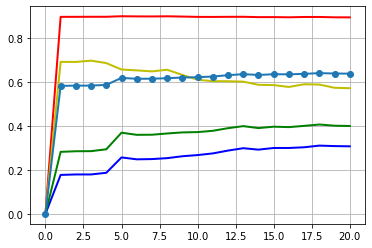

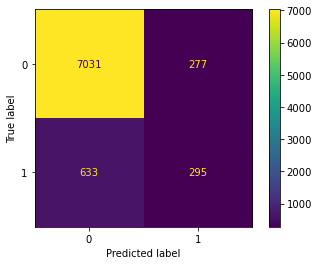

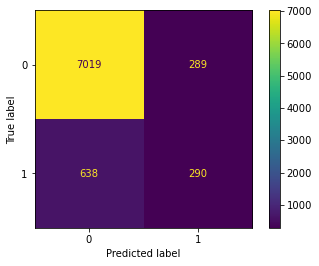

In [69]:
%%time
model_xg(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, count=20, message="Decision Tree with all training rows retained")

Decision Tree with all training rows retained
____________________________________________________________________________________________________
[18:43:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:44:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Accuracy at depth: 5 0.8518698397280233
Best Recall at depth: 1 0.7306034482758621
Best Precision at depth: 5 0.4008152173913043
Best F-score at depth: 6 0.49317335539925533
Best AUC-Score at depth: 7 0.7609298029556649
--------------------------------------------------------------------------

Best Accuracy wise: 
[18:44:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\prasa\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


TN: 6023  FP: 1285  FN: 303 TP: 625
[[6023 1285]
 [ 303  625]]
Accuracy is:  0.8518698397280233
Reacall is:  0.6357758620689655
Precision is:  0.4008152173913043
F-score is:  0.49166666666666664
AUC-Score is:  0.7575431034482758
--------------------------------------------------------------------------

Best Precision wise: 
[18:44:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TN: 6023  FP: 1285  FN: 303 TP: 625
[[6023 1285]
 [ 303  625]]
Accuracy is:  0.8518698397280233
Reacall is:  0.6357758620689655
Precision is:  0.4008152173913043
F-score is:  0.49166666666666664
AUC-Score is:  0.7575431034482758
--------------------------------------------------------------------------

Best Recall wise: 
[18:44:05] WARNING: C:/Users/Administra

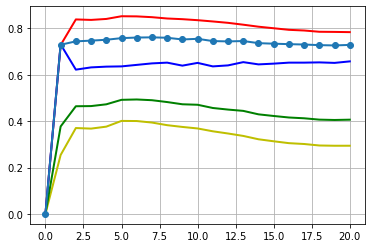

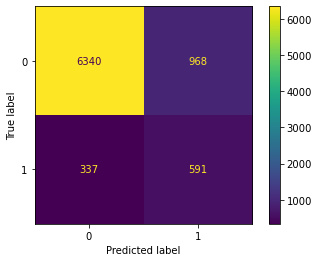

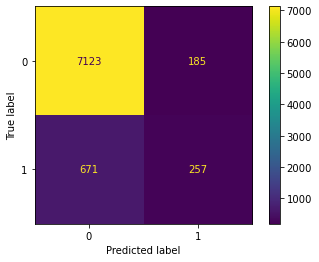

In [70]:
%%time
model_xg(X_train=X_train_2, y_train=y_train_2, X_test=X_test, y_test=y_test, count=20, message="Decision Tree with all training rows retained")

### 
________________________________________________________________

# Decision Tree Applied:
Bayesian Hyperhyperparameter optimization - Very important for hp search

In [43]:
def model_check(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model=DecisionTreeClassifier, count=20, message="Decision Tree"):
    print(message)
    print("____________________________________________________________________________________________________")
    acc = [0]
    recall = [0]
    precision = [0]
    fscore = [0]
    auc = [0]
    for i in range(1,count+1):
        model_clf = model(max_depth=i,random_state=42)
        model_clf.fit(X_train, y_train)
        y_predicted = model_clf.predict(X_test)
        acc.append(accuracy_score(y_test, y_predicted))
        recall.append(recall_score(y_test, y_predicted, pos_label=1))
        precision.append(precision_score(y_test, y_predicted, pos_label=1))
        fscore.append(f1_score(y_test, y_predicted, pos_label=1))
        auc.append(roc_auc_score(y_test, y_predicted))
    plt.plot(acc,"r-",linewidth=2,label="Accuracy")
    plt.plot(recall,"b-",linewidth=2,label="Recall")
    plt.plot(precision,"y-",linewidth=2,label="Precision")
    plt.plot(fscore,"g-",linewidth=2,label="F-score")
    plt.plot(auc,"o-",linewidth=2,label="AUC-Score")
#     plt.text("Minimum")
    plt.grid()
    print("Best Accuracy at depth:", np.argmax(acc), acc[np.argmax(acc)])
    print("Best Recall at depth:", np.argmax(recall), recall[np.argmax(recall)])
    print("Best Precision at depth:", np.argmax(precision), precision[np.argmax(precision)])
    print("Best F-score at depth:", np.argmax(fscore), fscore[np.argmax(fscore)])
    print("Best AUC-Score at depth:", np.argmax(auc), auc[np.argmax(auc)])
    print("--------------------------------------------------------------------------")
    print()

    print("Best Accuracy wise: ")
    tree_clf = model(max_depth=np.argmax(acc),random_state=42)
    tree_clf.fit(X_train, y_train)
    y_predicted = tree_clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
    print("TN:",tn," FP:", fp, " FN:", fn,"TP:", tp)
    print(confusion_matrix(y_test, y_predicted))
    print("Accuracy is: ", acc[np.argmax(acc)])
    print("Reacall is: ", recall[np.argmax(acc)])
    print("Precision is: ", precision[np.argmax(acc)])
    print("F-score is: ", fscore[np.argmax(acc)])
    print("AUC-Score is: ", auc[np.argmax(acc)])
    print("--------------------------------------------------------------------------")
    print()
    
    print("Best Precision wise: ")
    tree_clf = model(max_depth=np.argmax(precision),random_state=42)
    tree_clf.fit(X_train, y_train)
    y_predicted = tree_clf.predict(X_test)
    cm = confusion_matrix(y_test, y_predicted)
    tn, fp, fn, tp = cm.ravel()
    print("TN:",tn," FP:", fp, " FN:", fn,"TP:", tp)
    print(confusion_matrix(y_test, y_predicted))
    print("Accuracy is: ", acc[np.argmax(precision)])
    print("Reacall is: ", recall[np.argmax(precision)])
    print("Precision is: ", precision[np.argmax(precision)])
    print("F-score is: ", fscore[np.argmax(precision)])
    print("AUC-Score is: ", auc[np.argmax(precision)])
    print("--------------------------------------------------------------------------")
    print()
    

    print("Best Recall wise: ")
    tree_clf = model(max_depth=np.argmax(recall),random_state=42)
    tree_clf.fit(X_train, y_train)
    y_predicted = tree_clf.predict(X_test)
    cm = confusion_matrix(y_test, y_predicted)
    tn, fp, fn, tp = cm.ravel()
    print("TN:",tn," FP:", fp, " FN:", fn,"TP:", tp)
    print(cm)
    print("Accuracy is: ", acc[np.argmax(recall)])
    print("Reacall is: ", recall[np.argmax(recall)])
    print("Precision is: ", precision[np.argmax(recall)])
    print("F-score is: ", fscore[np.argmax(recall)])
    print("AUC-Score is: ", auc[np.argmax(recall)])
    print("--------------------------------------------------------------------------")
    print()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    print("Best F-score wise: ")
    tree_clf = model(max_depth=np.argmax(fscore),random_state=42)
    tree_clf.fit(X_train_1, y_train_1)
    y_predicted = tree_clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
    print("TN:",tn," FP:", fp, " FN:", fn,"TP:", tp)
    print(confusion_matrix(y_test, y_predicted))
    print("Accuracy is: ", acc[np.argmax(fscore)])
    print("Reacall is: ", recall[np.argmax(fscore)])
    print("Precision is: ", precision[np.argmax(fscore)])
    print("F-score is: ", fscore[np.argmax(fscore)])
    print("AUC-Score is: ", auc[np.argmax(fscore)])
    print("--------------------------------------------------------------------------")
    print()
    
    print("Best AUC-Score wise: ")
    tree_clf = model(max_depth=np.argmax(auc),random_state=42)
    tree_clf.fit(X_train_1, y_train_1)
    y_predicted = tree_clf.predict(X_test)
    cm = confusion_matrix(y_test, y_predicted)
    tn, fp, fn, tp = cm.ravel()
    print("TN:",tn," FP:", fp, " FN:", fn,"TP:", tp)
    print(cm)
    print("Accuracy is: ", acc[np.argmax(auc)])
    print("Reacall is: ", recall[np.argmax(auc)])
    print("Precision is: ", precision[np.argmax(auc)])
    print("F-score is: ", fscore[np.argmax(auc)])
    print("AUC-Score is: ", auc[np.argmax(auc)])
    print("--------------------------------------------------------------------------")
    print()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

Decision Tree with all training rows retained
____________________________________________________________________________________________________


C:\Users\prasa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Accuracy at depth: 5 0.9009227780475959
Best Recall at depth: 20 0.33405172413793105
Best Precision at depth: 2 0.6932773109243697
Best F-score at depth: 14 0.3891525423728813
Best AUC-Score at depth: 14 0.6368448960043787
--------------------------------------------------------------------------

Best Accuracy wise: 
TN: 7180  FP: 128  FN: 688 TP: 240
[[7180  128]
 [ 688  240]]
Accuracy is:  0.9009227780475959
Reacall is:  0.25862068965517243
Precision is:  0.6521739130434783
F-score is:  0.37037037037037046
AUC-Score is:  0.6205528188286809
--------------------------------------------------------------------------

Best Precision wise: 
TN: 7235  FP: 73  FN: 763 TP: 165
[[7235   73]
 [ 763  165]]
Accuracy is:  0.8984944147644488
Reacall is:  0.17780172413793102
Precision is:  0.6932773109243697
F-score is:  0.2830188679245283
AUC-Score is:  0.5839063355227148
--------------------------------------------------------------------------

Best Recall wise: 
TN: 6790  FP: 518  FN: 618

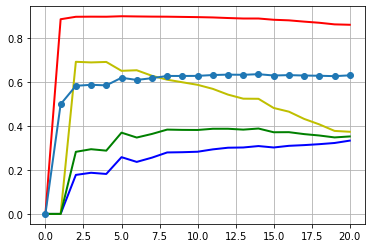

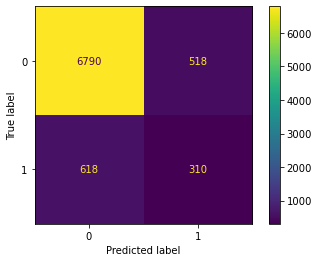

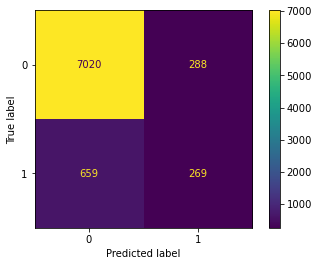

In [44]:
%%time
model_check(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model=DecisionTreeClassifier, count=20, message="Decision Tree with all training rows retained")

Decision Tree with unknown entry rows removed
____________________________________________________________________________________________________


C:\Users\prasa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Accuracy at depth: 5 0.9023797960174842
Best Recall at depth: 20 0.3275862068965517
Best Precision at depth: 6 0.7027027027027027
Best F-score at depth: 12 0.4027491408934708
Best AUC-Score at depth: 12 0.6418565270935961
--------------------------------------------------------------------------

Best Accuracy wise: 
TN: 7178  FP: 130  FN: 674 TP: 254
[[7178  130]
 [ 674  254]]
Accuracy is:  0.9023797960174842
Reacall is:  0.27370689655172414
Precision is:  0.6614583333333334
F-score is:  0.3871951219512195
AUC-Score is:  0.6279590859332239
--------------------------------------------------------------------------

Best Precision wise: 
TN: 7220  FP: 88  FN: 720 TP: 208
[[7220   88]
 [ 720  208]]
Accuracy is:  0.9018941233608548
Reacall is:  0.22413793103448276
Precision is:  0.7027027027027027
F-score is:  0.33986928104575165
AUC-Score is:  0.6060481663929939
--------------------------------------------------------------------------

Best Recall wise: 
TN: 6815  FP: 493  FN: 624 

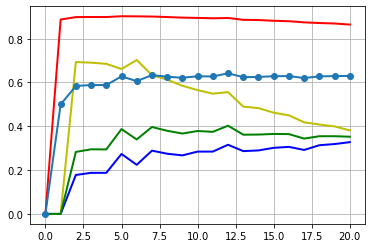

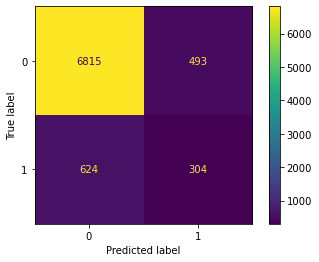

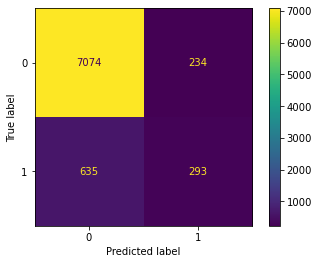

In [45]:
%%time
model_check(X_train=X_train_1, y_train=y_train_1, X_test=X_test, y_test=y_test, model=DecisionTreeClassifier, count=20, message="Decision Tree with unknown entry rows removed")

Decision Tree with unknown entry rows removed and downsampled
____________________________________________________________________________________________________
Best Accuracy at depth: 1 0.87821758135017
Best Recall at depth: 8 0.6767241379310345
Best Precision at depth: 1 0.46153846153846156
Best F-score at depth: 5 0.5020242914979758
Best AUC-Score at depth: 5 0.7502223590585659
--------------------------------------------------------------------------

Best Accuracy wise: 
TN: 6783  FP: 525  FN: 478 TP: 450
[[6783  525]
 [ 478  450]]
Accuracy is:  0.87821758135017
Reacall is:  0.4849137931034483
Precision is:  0.46153846153846156
F-score is:  0.4729374671571203
AUC-Score is:  0.7065373563218391
--------------------------------------------------------------------------

Best Precision wise: 
TN: 6783  FP: 525  FN: 478 TP: 450
[[6783  525]
 [ 478  450]]
Accuracy is:  0.87821758135017
Reacall is:  0.4849137931034483
Precision is:  0.46153846153846156
F-score is:  0.4729374671571203
A

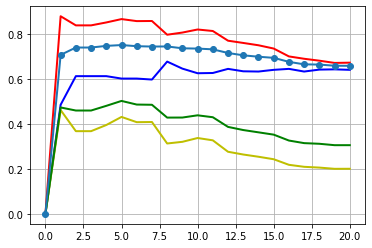

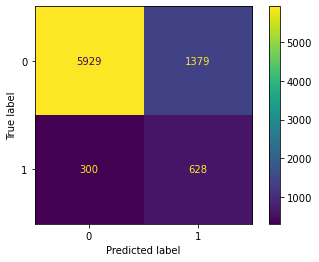

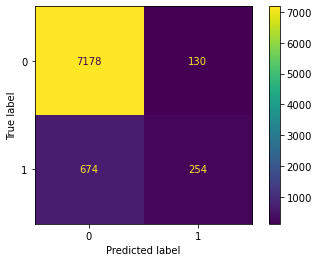

In [46]:
%%time
model_check(X_train=X_train_2, y_train=y_train_2, X_test=X_test, y_test=y_test, model=DecisionTreeClassifier, count=20, message="Decision Tree with unknown entry rows removed and downsampled")

Decision Tree  with unknown entry rows retained and downsampled
____________________________________________________________________________________________________
Best Accuracy at depth: 1 0.87821758135017
Best Recall at depth: 19 0.6584051724137931
Best Precision at depth: 1 0.46153846153846156
Best F-score at depth: 6 0.5150093808630394
Best AUC-Score at depth: 7 0.7603995621237001
--------------------------------------------------------------------------

Best Accuracy wise: 
TN: 6783  FP: 525  FN: 478 TP: 450
[[6783  525]
 [ 478  450]]
Accuracy is:  0.87821758135017
Reacall is:  0.4849137931034483
Precision is:  0.46153846153846156
F-score is:  0.4729374671571203
AUC-Score is:  0.7065373563218391
--------------------------------------------------------------------------

Best Precision wise: 
TN: 6783  FP: 525  FN: 478 TP: 450
[[6783  525]
 [ 478  450]]
Accuracy is:  0.87821758135017
Reacall is:  0.4849137931034483
Precision is:  0.46153846153846156
F-score is:  0.472937467157120

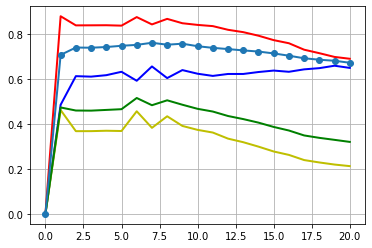

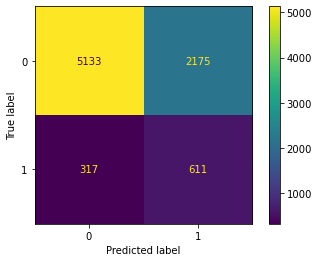

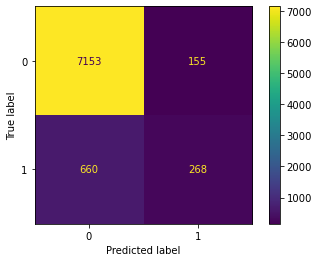

In [47]:
%%time
model_check(X_train=X_train_3, y_train=y_train_3, X_test=X_test, y_test=y_test, model=DecisionTreeClassifier, count=20, message="Decision Tree  with unknown entry rows retained and downsampled")


K is  0.3  _________________________________________________________________________________
yes count: 3063  no count: 918
Decision Tree  with unknown entry rows removed and downsampled and downsampling by factor of:0.3
____________________________________________________________________________________________________
Best Accuracy at depth: 18 0.47195240407965033
Best Recall at depth: 1 1.0
Best Precision at depth: 11 0.15676959619952494
Best F-score at depth: 11 0.26488294314381267
Best AUC-Score at depth: 7 0.6376231527093597
--------------------------------------------------------------------------

Best Accuracy wise: 
TN: 3129  FP: 4179  FN: 170 TP: 758
[[3129 4179]
 [ 170  758]]
Accuracy is:  0.47195240407965033
Reacall is:  0.8168103448275862
Precision is:  0.15353453514279927
F-score is:  0.2584825234441603
AUC-Score is:  0.6224856321839081
--------------------------------------------------------------------------

Best Precision wise: 
TN: 3048  FP: 4260  FN: 136 TP: 792
[

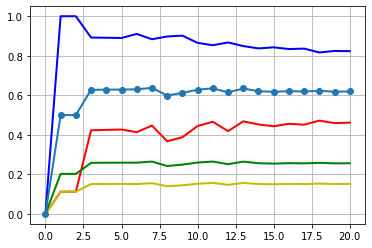

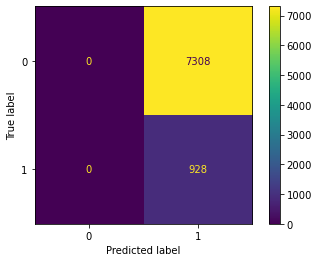

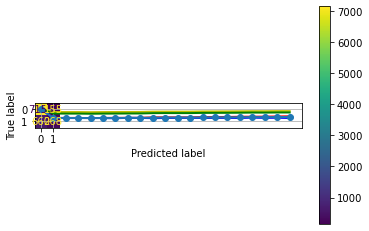

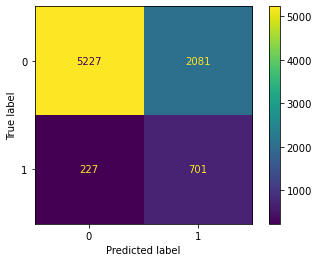

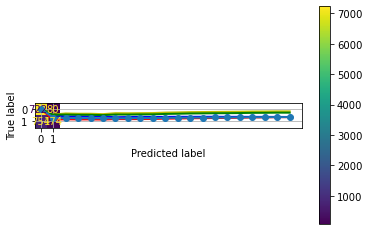

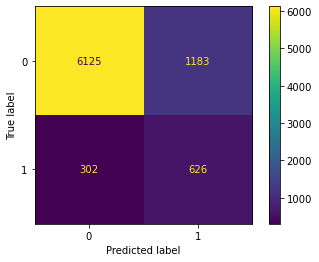

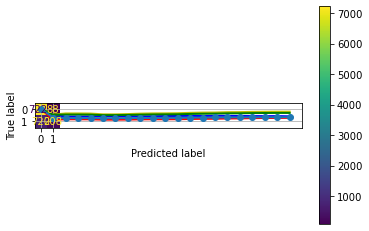

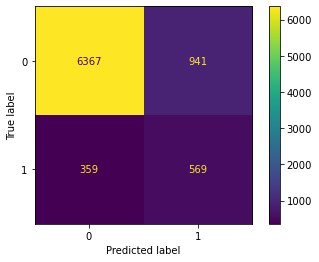

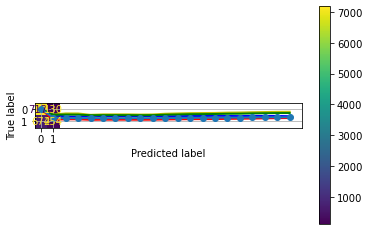

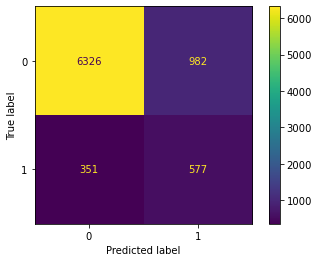

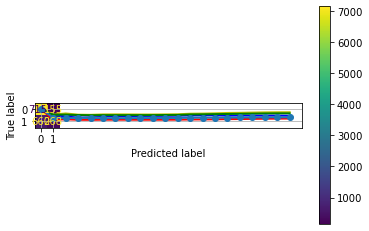

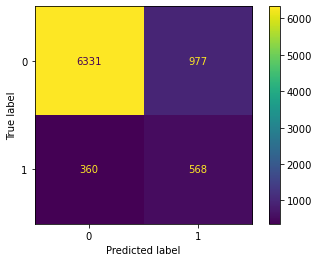

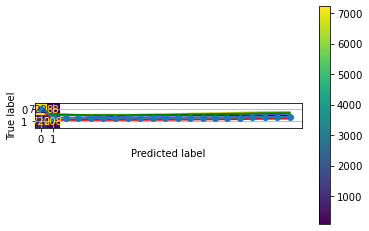

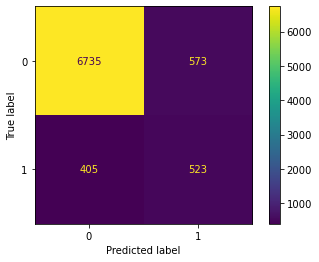

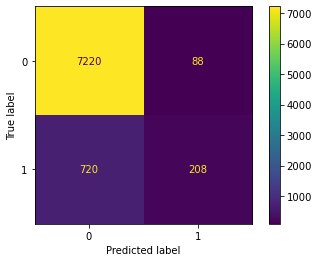

In [48]:
%%time
i=0.3
while(i<2.2):
    print()
    print("K is ",i," _________________________________________________________________________________")
    X, y = balance_by_y(X_train_1, y_train_1, k=i)  #downsampling after removing unknowns
    if "y" in X_train_1.columns:
        X_train_1 = X_train_1.drop(labels="y", axis=1)    #check
    model_check(X_train=X, y_train=y, X_test=X_test, y_test=y_test, model=DecisionTreeClassifier, count=20, message="Decision Tree  with unknown entry rows removed and downsampled and downsampling by factor of:"+str(i))
    print()
    print()
    print("$$$$$$$$$______________$$$$$$$$$$$$$$_________________$$$$$$$$$$$$$")
    i+=0.3


K is  0.3  _________________________________________________________________________________
yes count: 3711  no count: 1113
Decision Tree  with unknown entry rows retained and downsampled by factor of:0.3
____________________________________________________________________________________________________
Best Accuracy at depth: 20 0.4174356483729966
Best Recall at depth: 1 1.0
Best Precision at depth: 20 0.14033457249070633
Best F-score at depth: 20 0.23937856689917564
Best AUC-Score at depth: 5 0.591064586754242
--------------------------------------------------------------------------

Best Accuracy wise: 
TN: 2683  FP: 4625  FN: 173 TP: 755
[[2683 4625]
 [ 173  755]]
Accuracy is:  0.4174356483729966
Reacall is:  0.8135775862068966
Precision is:  0.14033457249070633
F-score is:  0.23937856689917564
AUC-Score is:  0.5903547482211275
--------------------------------------------------------------------------

Best Precision wise: 
TN: 2683  FP: 4625  FN: 173 TP: 755
[[2683 4625]
 [ 17

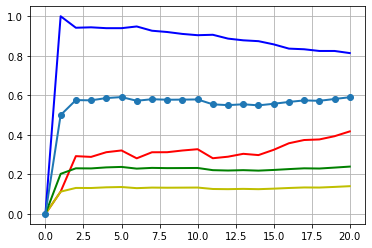

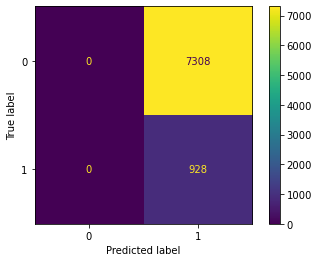

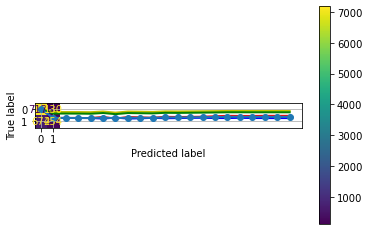

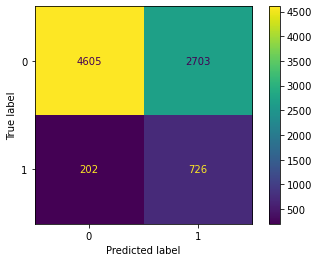

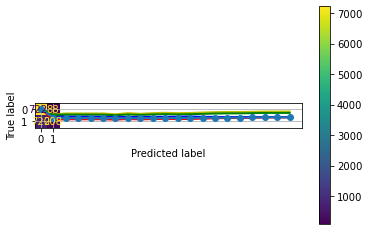

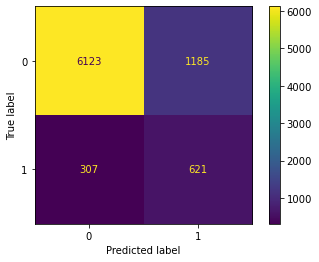

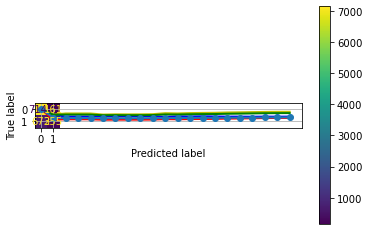

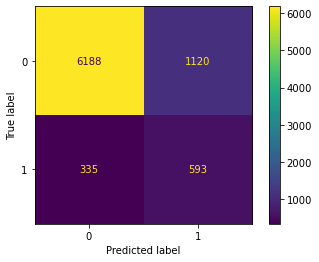

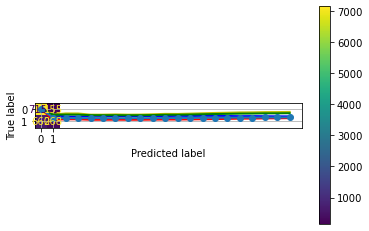

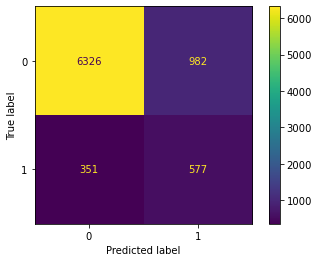

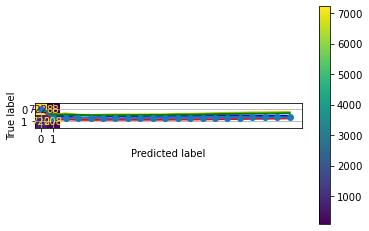

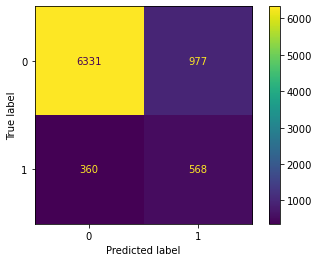

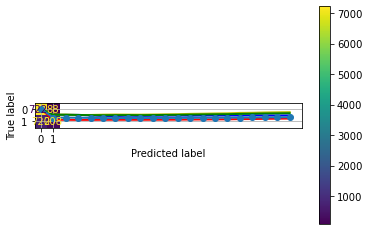

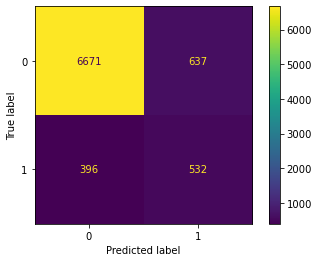

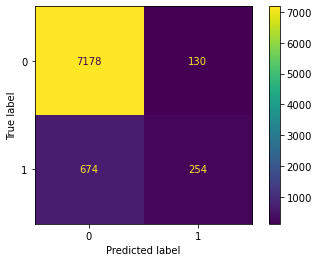

In [49]:
%%time
i=0.3
while(i<2.2):
    print()
    print("K is ",i," _________________________________________________________________________________")
    X, y = balance_by_y(X_train, y_train, k=i)  #downsampling without removing unknowns
    if "y" in X_train.columns:
        X_train = X_train.drop(labels="y", axis=1)    #check
    model_check(X_train=X, y_train=y, X_test=X_test, y_test=y_test, model=DecisionTreeClassifier, count=20, message="Decision Tree  with unknown entry rows retained and downsampled by factor of:"+str(i))
    print()
    print()
    print("$$$$$$$$$______________$$$$$$$$$$$$$$_________________$$$$$$$$$$$$$")
    i+=0.3

## Summary for Decision Tree:
    Highest recall acheived: 67.67% at depth 8 for X_train_2
    Highest accuracy achieved: 90.23% at depth 5 for X_train_1
    Highest precision achieved: 70.27% at depth 6 for X_train_1
    Highest f-score achieved: 51.50% at depth 6 for X_train_2
    Highest AUC-score achieved: 76.03% at depth 7 for X_train_3

______________________________________________________________________________________
# Random Forest Applied:
Grid search

In [50]:
def model_check_R(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model=RandomForestClassifier, count=100, message="Decision Tree"):
    print(message)
    print("____________________________________________________________________________________________________")
    acc = [0]
    recall = [0]
    precision = [0]
    fscore = [0]
    auc = [0]
    for i in range(1,count+1):
        model_clf = model(n_estimators=i,random_state=42)
        model_clf.fit(X_train, y_train)
        y_predicted = model_clf.predict(X_test)
        acc.append(accuracy_score(y_test, y_predicted))
        recall.append(recall_score(y_test, y_predicted, pos_label=1))
        precision.append(precision_score(y_test, y_predicted, pos_label=1))
        fscore.append(f1_score(y_test, y_predicted, pos_label=1))
        auc.append(roc_auc_score(y_test, y_predicted))
    plt.plot(acc,"r-",linewidth=2,label="Accuracy")
    plt.plot(recall,"b-",linewidth=2,label="Recall")
    plt.plot(precision,"y-",linewidth=2,label="Precision")
    plt.plot(fscore,"g-",linewidth=2,label="F-score")
    plt.plot(auc,"o-",linewidth=2,label="AUC-Score")
    plt.grid()
    print("Best Accuracy at tree-count:", np.argmax(acc), acc[np.argmax(acc)])
    print("Best Recall at tree-count:", np.argmax(recall), recall[np.argmax(recall)])
    print("Best Precision at tree-count:", np.argmax(precision), precision[np.argmax(precision)])
    print("Best F-score at tree-count:", np.argmax(fscore), fscore[np.argmax(fscore)])
    print("Best AUC-Score at tree-count:", np.argmax(auc), auc[np.argmax(auc)])
    print("--------------------------------------------------------------------------")
    print()

    print("Best Accuracy wise: ")
    tree_clf = model(n_estimators=np.argmax(acc),random_state=42)
    tree_clf.fit(X_train, y_train)
    y_predicted = tree_clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
    print("TN:",tn," FP:", fp, " FN:", fn,"TP:", tp)
    print(confusion_matrix(y_test, y_predicted))
    print("Accuracy is: ", acc[np.argmax(acc)])
    print("Reacall is: ", recall[np.argmax(acc)])
    print("Precision is: ", precision[np.argmax(acc)])
    print("F-score is: ", fscore[np.argmax(acc)])
    print("AUC-Score is: ", auc[np.argmax(acc)])
    print("--------------------------------------------------------------------------")
    print()
    
    print("Best Precision wise: ")
    tree_clf = model(n_estimators=np.argmax(precision),random_state=42)
    tree_clf.fit(X_train, y_train)
    y_predicted = tree_clf.predict(X_test)
    cm = confusion_matrix(y_test, y_predicted)
    tn, fp, fn, tp = cm.ravel()
    print("TN:",tn," FP:", fp, " FN:", fn,"TP:", tp)
    print(confusion_matrix(y_test, y_predicted))
    print("Accuracy is: ", acc[np.argmax(precision)])
    print("Reacall is: ", recall[np.argmax(precision)])
    print("Precision is: ", precision[np.argmax(precision)])
    print("F-score is: ", fscore[np.argmax(precision)])
    print("AUC-Score is: ", auc[np.argmax(precision)])
    print("--------------------------------------------------------------------------")
    print()
    

    print("Best Recall wise: ")
    tree_clf = model(n_estimators=np.argmax(recall),random_state=42)
    tree_clf.fit(X_train, y_train)
    y_predicted = tree_clf.predict(X_test)
    cm = confusion_matrix(y_test, y_predicted)
    tn, fp, fn, tp = cm.ravel()
    print("TN:",tn," FP:", fp, " FN:", fn,"TP:", tp)
    print(cm)
    print("Accuracy is: ", acc[np.argmax(recall)])
    print("Reacall is: ", recall[np.argmax(recall)])
    print("Precision is: ", precision[np.argmax(recall)])
    print("F-score is: ", fscore[np.argmax(recall)])
    print("AUC-Score is: ", auc[np.argmax(recall)])
    print("--------------------------------------------------------------------------")
    print()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    print("Best F-score wise: ")
    tree_clf = model(n_estimators=np.argmax(fscore),random_state=42)
    tree_clf.fit(X_train_1, y_train_1)
    y_predicted = tree_clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
    print("TN:",tn," FP:", fp, " FN:", fn,"TP:", tp)
    print(confusion_matrix(y_test, y_predicted))
    print("Accuracy is: ", acc[np.argmax(fscore)])
    print("Reacall is: ", recall[np.argmax(fscore)])
    print("Precision is: ", precision[np.argmax(fscore)])
    print("F-score is: ", fscore[np.argmax(fscore)])
    print("AUC-Score is: ", auc[np.argmax(fscore)])
    print("--------------------------------------------------------------------------")
    print()
    
    print("Best AUC-Score wise: ")
    tree_clf = model(max_depth=np.argmax(auc),random_state=42)
    tree_clf.fit(X_train_1, y_train_1)
    y_predicted = tree_clf.predict(X_test)
    cm = confusion_matrix(y_test, y_predicted)
    tn, fp, fn, tp = cm.ravel()
    print("TN:",tn," FP:", fp, " FN:", fn,"TP:", tp)
    print(cm)
    print("Accuracy is: ", acc[np.argmax(auc)])
    print("Reacall is: ", recall[np.argmax(auc)])
    print("Precision is: ", precision[np.argmax(auc)])
    print("F-score is: ", fscore[np.argmax(auc)])
    print("AUC-Score is: ", auc[np.argmax(auc)])
    print("--------------------------------------------------------------------------")
    print()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

RF with all training rows
____________________________________________________________________________________________________
Best Accuracy at tree-count: 14 0.8955803788246721
Best Recall at tree-count: 1 0.33620689655172414
Best Precision at tree-count: 14 0.5745614035087719
Best F-score at tree-count: 17 0.39444444444444443
Best AUC-Score at tree-count: 17 0.6374178981937603
--------------------------------------------------------------------------

Best Accuracy wise: 
TN: 7114  FP: 194  FN: 666 TP: 262
[[7114  194]
 [ 666  262]]
Accuracy is:  0.8955803788246721
Reacall is:  0.2823275862068966
Precision is:  0.5745614035087719
F-score is:  0.3786127167630058
AUC-Score is:  0.6278906677613575
--------------------------------------------------------------------------

Best Precision wise: 
TN: 7114  FP: 194  FN: 666 TP: 262
[[7114  194]
 [ 666  262]]
Accuracy is:  0.8955803788246721
Reacall is:  0.2823275862068966
Precision is:  0.5745614035087719
F-score is:  0.3786127167630058
AUC

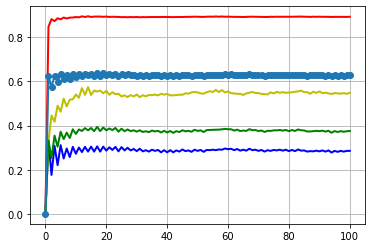

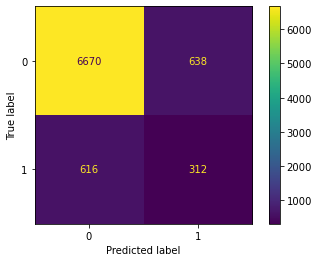

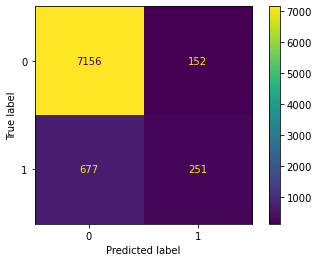

In [51]:
%%time
model_check_R(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model=RandomForestClassifier, count=100, message="RF with all training rows")

RF with unknown entry rows removed
____________________________________________________________________________________________________
Best Accuracy at tree-count: 40 0.8959446333171442
Best Recall at tree-count: 1 0.3254310344827586
Best Precision at tree-count: 40 0.576017130620985
Best F-score at tree-count: 17 0.4
Best AUC-Score at tree-count: 17 0.6406421045429666
--------------------------------------------------------------------------

Best Accuracy wise: 
TN: 7110  FP: 198  FN: 659 TP: 269
[[7110  198]
 [ 659  269]]
Accuracy is:  0.8959446333171442
Reacall is:  0.28987068965517243
Precision is:  0.576017130620985
F-score is:  0.385663082437276
AUC-Score is:  0.6313885467980295
--------------------------------------------------------------------------

Best Precision wise: 
TN: 7110  FP: 198  FN: 659 TP: 269
[[7110  198]
 [ 659  269]]
Accuracy is:  0.8959446333171442
Reacall is:  0.28987068965517243
Precision is:  0.576017130620985
F-score is:  0.385663082437276
AUC-Score is: 

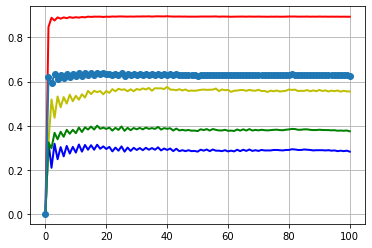

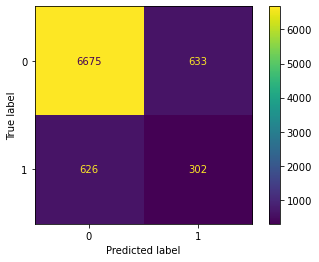

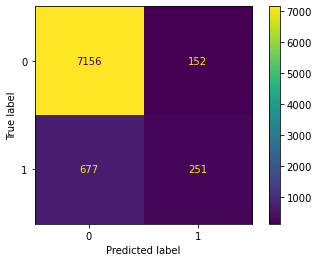

In [52]:
%%time
model_check_R(X_train=X_train_1, y_train=y_train_1, X_test=X_test, y_test=y_test, model=RandomForestClassifier, count=100, message="RF with unknown entry rows removed")

RF with unknown entry rows removed and downsampled
____________________________________________________________________________________________________
Best Accuracy at tree-count: 2 0.8043953375424964
Best Recall at tree-count: 11 0.6853448275862069
Best Precision at tree-count: 68 0.3074656188605108
Best F-score at tree-count: 68 0.4224021592442645
Best AUC-Score at tree-count: 49 0.7409003831417623
--------------------------------------------------------------------------

Best Accuracy wise: 
TN: 6164  FP: 1144  FN: 467 TP: 461
[[6164 1144]
 [ 467  461]]
Accuracy is:  0.8043953375424964
Reacall is:  0.49676724137931033
Precision is:  0.2872274143302181
F-score is:  0.363995262534544
AUC-Score is:  0.670113232074439
--------------------------------------------------------------------------

Best Precision wise: 
TN: 5898  FP: 1410  FN: 302 TP: 626
[[5898 1410]
 [ 302  626]]
Accuracy is:  0.7921321029626032
Reacall is:  0.6745689655172413
Precision is:  0.3074656188605108
F-score is:

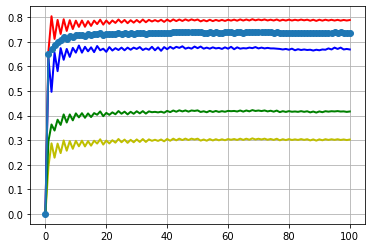

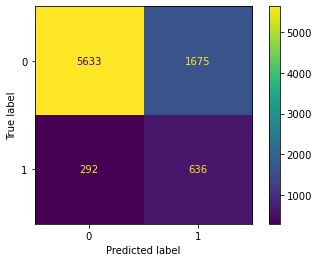

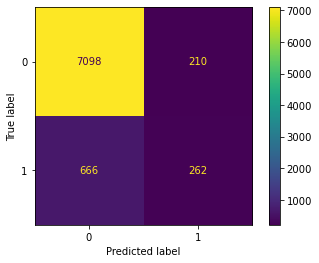

In [53]:
%%time
model_check_R(X_train=X_train_2, y_train=y_train_2, X_test=X_test, y_test=y_test, model=RandomForestClassifier, count=100, message="RF with unknown entry rows removed and downsampled")

RF with unknown entry rows retained and downsampled
____________________________________________________________________________________________________
Best Accuracy at tree-count: 2 0.7965031568722681
Best Recall at tree-count: 25 0.6982758620689655
Best Precision at tree-count: 78 0.3052073288331726
Best F-score at tree-count: 78 0.42171885409726845
Best AUC-Score at tree-count: 78 0.7424654488232075
--------------------------------------------------------------------------

Best Accuracy wise: 
TN: 6076  FP: 1232  FN: 444 TP: 484
[[6076 1232]
 [ 444  484]]
Accuracy is:  0.7965031568722681
Reacall is:  0.521551724137931
Precision is:  0.28205128205128205
F-score is:  0.3661119515885023
AUC-Score is:  0.6764846743295019
--------------------------------------------------------------------------

Best Precision wise: 
TN: 5867  FP: 1441  FN: 295 TP: 633
[[5867 1441]
 [ 295  633]]
Accuracy is:  0.7892180670228266
Reacall is:  0.6821120689655172
Precision is:  0.3052073288331726
F-score 

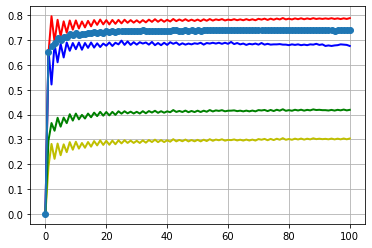

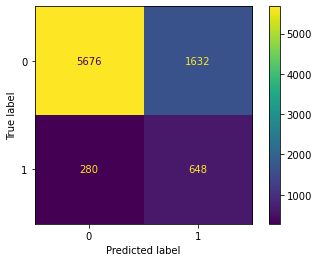

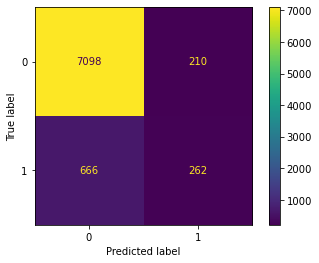

In [54]:
%%time
model_check_R(X_train=X_train_3, y_train=y_train_3, X_test=X_test, y_test=y_test, model=RandomForestClassifier, count=100, message="RF with unknown entry rows retained and downsampled")

# Summary for Random Forest:
    Highest recall acheived: 69.82% at trees_count 25 for X_train_3
    Highest accuracy achieved: 89.59% at trees_count 40 for X_train_1
    Highest precision achieved: 57.45% at trees_count 14 for X_train
    Highest f-score achieved: 42.24% at trees_count 68 for X_train_2
    Highest AUC-score achieved: 76.03% at trees_count 68 for X_train_3
 

______________________________________________________________________________________________________________
# Naive Bayes Applied:

In [55]:
def naive(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model=GaussianNB, scale = False, message="Guassian_NB with all training rows"):
    print("Scale: ", scale,"->", message)
    print("____________________________________________________________________________________________________")
    if scale:
        scaler = RobustScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    model_clf = model()
    model_clf.fit(X_train, y_train)
    y_predicted = model_clf.predict(X_test)
    print("accuracy: ",accuracy_score(y_test, y_predicted))
    print("recall: ",recall_score(y_test, y_predicted, pos_label=1))
    print("precision: ",precision_score(y_test, y_predicted, pos_label=1))
    print("f1_score: ",f1_score(y_test, y_predicted, pos_label=1))
    print("AUC-Score: ", roc_auc_score(y_test, y_predicted))
    cm = confusion_matrix(y_test, y_predicted)
    tn, fp, fn, tp = cm.ravel()
    print("TN:",tn," FP:", fp, " FN:", fn,"TP:", tp)
    print(confusion_matrix(y_test, y_predicted))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

Scale:  True -> Guassian_NB with all training rows
____________________________________________________________________________________________________
accuracy:  0.8569694026226323
recall:  0.47198275862068967
precision:  0.38898756660746003
f1_score:  0.4264849074975657
AUC-Score:  0.6889196770662288
TN: 6620  FP: 688  FN: 490 TP: 438
[[6620  688]
 [ 490  438]]
Wall time: 236 ms


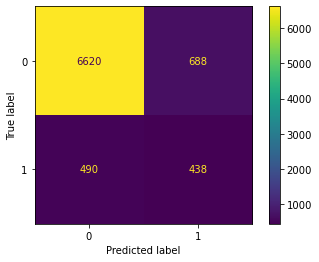

In [56]:
%%time
naive(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model=GaussianNB, scale = True, message="Guassian_NB with all training rows")


Scale:  False -> Guassian_NB with all training rows
____________________________________________________________________________________________________
accuracy:  0.8569694026226323
recall:  0.47198275862068967
precision:  0.38898756660746003
f1_score:  0.4264849074975657
AUC-Score:  0.6889196770662288
TN: 6620  FP: 688  FN: 490 TP: 438
[[6620  688]
 [ 490  438]]
Wall time: 147 ms


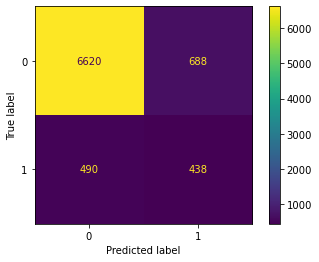

In [57]:
%%time
naive(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model=GaussianNB, scale = False, message="Guassian_NB with all training rows")


Scale:  True -> Guassian_NB with unknown entry training rows removed
____________________________________________________________________________________________________
accuracy:  0.8668042739193783
recall:  0.4482758620689655
precision:  0.4155844155844156
f1_score:  0.4313115603939865
AUC-Score:  0.6841133004926109
TN: 6723  FP: 585  FN: 512 TP: 416
[[6723  585]
 [ 512  416]]
Wall time: 218 ms


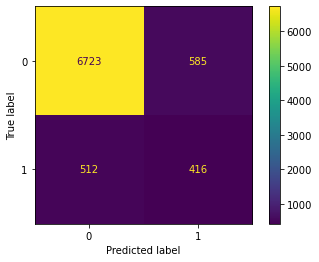

In [58]:
%%time
naive(X_train=X_train_1, y_train=y_train_1, X_test=X_test, y_test=y_test, model=GaussianNB, scale = True, message="Guassian_NB with unknown entry training rows removed")


Scale:  False -> Guassian_NB with unknown entry training rows removed
____________________________________________________________________________________________________
accuracy:  0.8668042739193783
recall:  0.4482758620689655
precision:  0.4155844155844156
f1_score:  0.4313115603939865
AUC-Score:  0.6841133004926109
TN: 6723  FP: 585  FN: 512 TP: 416
[[6723  585]
 [ 512  416]]
Wall time: 147 ms


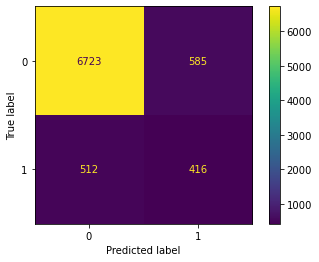

In [59]:
%%time
naive(X_train=X_train_1, y_train=y_train_1, X_test=X_test, y_test=y_test, model=GaussianNB, scale = False, message="Guassian_NB with unknown entry training rows removed")


Scale:  True -> Guassian_NB with unknown entry training rows removed and downsampled
____________________________________________________________________________________________________
accuracy:  0.8592763477416221
recall:  0.46012931034482757
precision:  0.3935483870967742
f1_score:  0.42424242424242425
AUC-Score:  0.6850454980842913
TN: 6650  FP: 658  FN: 501 TP: 427
[[6650  658]
 [ 501  427]]
Wall time: 150 ms


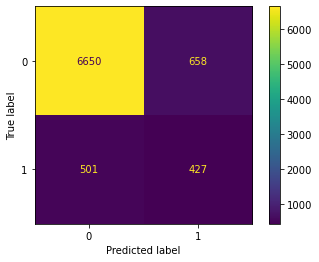

In [60]:
%%time
naive(X_train=X_train_2, y_train=y_train_2, X_test=X_test, y_test=y_test, model=GaussianNB, scale = True, message="Guassian_NB with unknown entry training rows removed and downsampled")


Scale:  False -> Guassian_NB with unknown entry training rows removed and downsampled
____________________________________________________________________________________________________
accuracy:  0.8592763477416221
recall:  0.46012931034482757
precision:  0.3935483870967742
f1_score:  0.42424242424242425
AUC-Score:  0.6850454980842913
TN: 6650  FP: 658  FN: 501 TP: 427
[[6650  658]
 [ 501  427]]
Wall time: 116 ms


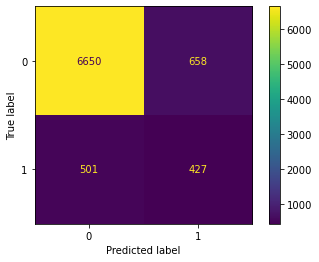

In [61]:
%%time
naive(X_train=X_train_2, y_train=y_train_2, X_test=X_test, y_test=y_test, model=GaussianNB, scale = False, message="Guassian_NB with unknown entry training rows removed and downsampled")


Scale:  True -> Guassian_NB with unknown entry training rows retained and downsampled
____________________________________________________________________________________________________
accuracy:  0.8404565322972317
recall:  0.5226293103448276
precision:  0.35766961651917406
f1_score:  0.4246935201401051
AUC-Score:  0.701722427476738
TN: 6437  FP: 871  FN: 443 TP: 485
[[6437  871]
 [ 443  485]]
Wall time: 150 ms


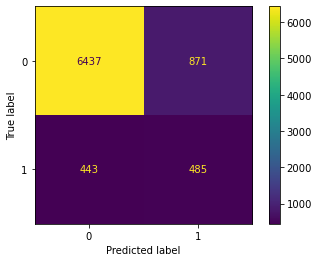

In [62]:
%%time
naive(X_train=X_train_3, y_train=y_train_3, X_test=X_test, y_test=y_test, model=GaussianNB, scale = True, message="Guassian_NB with unknown entry training rows retained and downsampled")


Scale:  False -> Guassian_NB with unknown entry training rows retained and downsampled
____________________________________________________________________________________________________
accuracy:  0.8404565322972317
recall:  0.5226293103448276
precision:  0.35766961651917406
f1_score:  0.4246935201401051
AUC-Score:  0.701722427476738
TN: 6437  FP: 871  FN: 443 TP: 485
[[6437  871]
 [ 443  485]]
Wall time: 118 ms


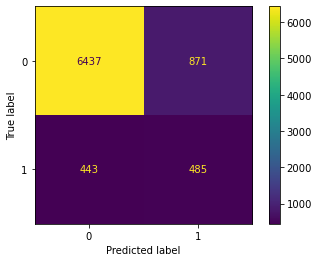

In [63]:
%%time
naive(X_train=X_train_3, y_train=y_train_3, X_test=X_test, y_test=y_test, model=GaussianNB, scale = False, message="Guassian_NB with unknown entry training rows retained and downsampled")


## Summary for Gaussian Naive-Bayes:
    Recall acheived: 52.26% for X_train_3 with/without scaling
    Accuracy achieved: 86.68% for X_train_1 with/without scaling
    Precision achieved: 41.55% for X_train_1 with/without scaling
    F-score achieved: 43.13% for X_train_1 with/without scaling
    AUC-score achieved: 70.17% for X_train_3 with/without scaling
    
___________________________________________________

___________________________________________________________________________
# Computing Complexities for the various models:

## Decision Tree:    (n = number of training data points, d = number of features in the data)
    Time Complexity -> O(n*log(n)*d)   #nlog(n)->to traverse a particular feature
    Space Complexity -> O(max_depth)

## Random Forest:    (n = number of training data points, d = number of features in the data, k = number of trees)
    Time Complexity -> O(n*log(n)*d*k)
    Space Complexity -> O(max_depth*k)

## Naive Bayes:      (n = number of training data points, d= number of features in the data, c = no. of classess to predict from)
    Time Complexity -> O(n*d)
    Space Complexity -> O(c*d)
_____________________________________________________

___________________________________________________________________________________________
## Summary with 'Duration' Column retained for Decision Tree:
    Highest recall acheived: 96.0% at depth 4 in DT for X_train_2
    Highest accuracy achieved: 91.4% at depth 6 in DT for X_train
    Highest precision achieved: 65.3% at depth 5 in DT for X_train
    Highest f-score achieved: 61.3% at depth 7 in DT for X_train
    Highest AUC-score achieved: 87.93% at depth 5 in DT for X_train_2
    DT - Decision Tree

# Evaluation Metric to Compare the Performance of the Three Classifiers

| Classifier| Highest Precision | Highest Recall | Highest F-score | Highest Accuracy  | AUC-score | Precision (Max. F-score) | Recall (Max. F-score) | Accuracy (Max. F-score) |
|---|---|---|---|---|---|---|---|---|
|Decision Tree|70.27%|67.67%| 51.5%| 90.23%|76.03%|43.02%|60.12%|86.55%|
|Random Forest|57.45%|69.82%|42.24%|89.59%|76.03%|30.74%|67.45%|79.21%|
|Naive Bayes|41.55%|52.26%|43.13%|86.68%|70.17%|41.55%|44.82%|86.68%|
|DT - D|65.3%|96.0%|59.53%|91.4%|87.93%|45.34%|86.63%|86.72%|

DT - D: Decision Tree with 'Duration' Column Retained     
n: Number of training data points     
d: Number of features in data     
k: Number of trees     
c: Number of Classes to predict from     
l: Maximum Depth of the tree


# Final-Selection:
    * Each model gives a certain level of best metric scores but at different configurations. However, we need a single classifier which can give us a good trade off between recall and precision.
    * If we have a high recall, we are losing out on precison and hence we are able to classify most positives in the test set correctly at the cost of mis-classifying many actual negatives as false positives. This would again increase the time for manual verification.
    * If we have a high precision, the we are missing out on classifying many actual positives as true positives leading to loss in buisiness and wasteful usage of resources in getting positive conversions.
    * Taking the above two points into consideration, we are opting to go for a trade-off between precision and recall & choose the highest f-score for a model as our model.
So, from the above tabulation, the Decision Tree with Accuracy-86.55%, Recall-60.12%, Precision-43.02% could be a possible candidate from the current setting.

# Possible Improvements:
    * We could build a model with 2 models constituted together. 
      -> The first model would have a high recall to capture maximum positives.
      -> The second model would then have a high precision on the positive predictions of the first model to filter out the false positives.
    * This approach could lead to a better solution in finally classifying a client would or would not subscribe the term deposit.